### Overview
The primary objective of this project is to analyze the factors contributing to the reported decline in sales for SalesEase, an online retailer, and provide insights to reverse this trend. 


**The Issue: Declining Sales**
- Six months of continuous decline in sales reported by the SalesEase management.
- Concerns about the sustainability of the business.
- Need to understand underlying factors affecting sales performance.


**Solution: Conduct Exploratory Data Analysis (EDA) to uncover insights**

### Project Steps
1. Data Exploration
2. Time Series Analysis
3. Customer Segmentation Analysis
4. Product Analysis
5. Payment and Returns Analysis
6. Summary

## 1. Loading, inspecting and validating the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('../data/ShopEase.csv')
df.shape

(1000, 12)

In [3]:
df.head()

,OrderID,ProductID,Category,ProductName,Quantity,Price,TotalAmount,OrderDate,CustomerID,PaymentMethod,SalesChannel,IsReturned
0,1,272,Electronics,Product_272,3,54.21,162.63,2022-04-21 01:48:37,26,Credit Card,In-Store,1
1,2,147,Electronics,Product_147,3,163.68,491.04,2022-02-26 03:09:32,38,Cash,Website,1
2,3,217,Fashion,Product_217,5,205.01,1025.05,2022-07-24 07:00:57,271,Cash,Website,0
3,4,292,Electronics,Product_292,4,163.13,652.52,2022-01-09 09:49:05,414,Cash,Website,1
4,5,423,Fashion,Product_423,3,608.73,1826.19,2022-05-19 09:38:52,368,Cash,Mobile App,1


In [4]:
duplicate_rows = df.duplicated()
duplicate_rows.sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OrderID        1000 non-null   int64  
 1   ProductID      1000 non-null   int64  
 2   Category       1000 non-null   object 
 3   ProductName    1000 non-null   object 
 4   Quantity       1000 non-null   int64  
 5   Price          1000 non-null   float64
 6   TotalAmount    1000 non-null   float64
 7   OrderDate      1000 non-null   object 
 8   CustomerID     1000 non-null   int64  
 9   PaymentMethod  1000 non-null   object 
 10  SalesChannel   1000 non-null   object 
 11  IsReturned     1000 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 93.9+ KB


**Observations and insights**

'OrderDate' column needs to be converted to datetime format for plotting and time-based analysis.

### Code optimisation: functions

In [227]:
def format_currency(amount, decimals=1):
  """
  Formats a numeric value into currency format with thousands separators.
  Args:
      amount: The numeric value to format.
      decimals: The number of decimal places to display (default: 1).
  Returns:
      A string representation of the amount in currency format.
  """
  return f'${amount/1000:,.{decimals}f}K'

## 2. Time Series Analysis

In [6]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

In [7]:
# Data prep. for plotting: Extract the month and year from 'OrderDate'
df['Month'] = df['OrderDate'].dt.strftime('%b')
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)
month_sales = df[df['IsReturned'] != 1].groupby('Month', observed=False)['TotalAmount'].sum().reset_index()
month_sales

,Month,TotalAmount
0,Jan,85797.38
1,Feb,62088.59
2,Mar,81367.19
3,Apr,75378.10
4,May,90614.47
5,Jun,78304.29
6,Jul,85079.52
7,Aug,78412.99


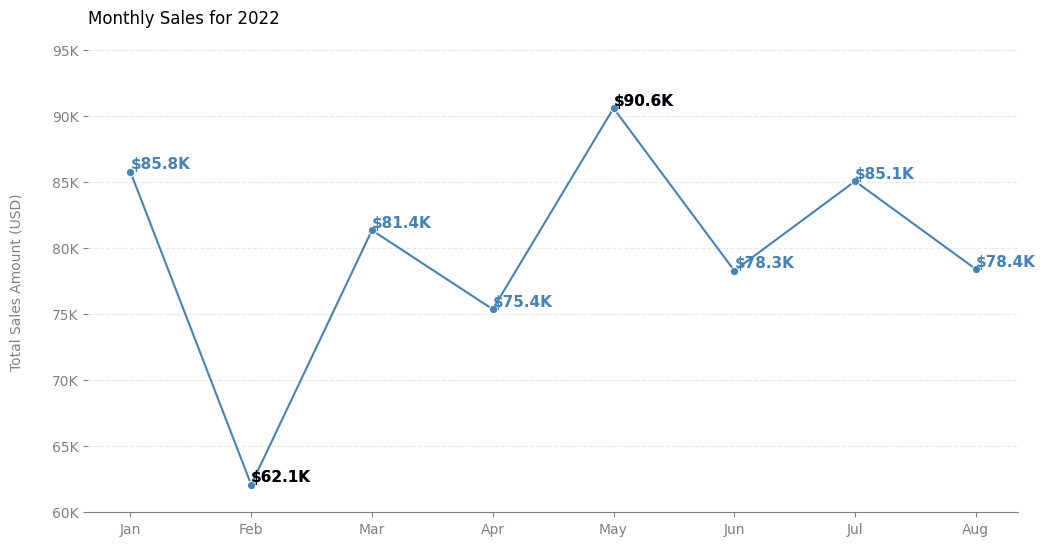

In [257]:
plt.figure(figsize=(12, 6))
g = sns.lineplot(x='Month', y='TotalAmount', data=month_sales, marker='o', color='steelblue')
plt.title('Monthly Sales for 2022', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
ylabels = [f'{y:,.0f}K' for y in g.get_yticks() / 1000]
g.set_yticks(g.get_yticks())
g.set_yticklabels(ylabels)
plt.ylabel('Total Sales Amount (USD)', color='grey', fontsize=10, labelpad=20)
plt.xlabel(None)

sns.despine()
plt.grid(axis='y', linestyle='--', color='lightgrey', alpha=0.5)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')

for index, row in month_sales.iterrows():
     plt.text(row['Month'], row['TotalAmount'], format_currency(row['TotalAmount']), 
              ha='left', va='bottom', color='steelblue', fontsize=11, fontweight='bold')
# Change text colour for max and min sales amount
max_s = month_sales.loc[month_sales['TotalAmount'].idxmax()]
min_s = month_sales.loc[month_sales['TotalAmount'].idxmin()]
plt.text(max_s['Month'], max_s['TotalAmount'], format_currency(max_s['TotalAmount']), 
         ha='left', va='bottom', fontsize=11, fontweight='bold')
plt.text(min_s['Month'], min_s['TotalAmount'], format_currency(min_s['TotalAmount']), 
         ha='left', va='bottom', fontsize=11, fontweight='bold')
plt.show()

**Observations and insights**

Although a comprehensive understanding of seasonal trends would require additional data, the trend observed here suggests that the business experiences fluctuations in demand throughout the year. 

Months like January, May, and July show higher total sales amounts compared to other months, with February sales being the lowest.
[Holiday seasons, promotions](https://usapostline.com/en/articles/sales-calendar-in-usa-best-shopping-days), [product releases or special events](https://opas.com/blog/the-ultimate-us-sales-dates-cheat-sheet/) might play a role here and need to be explored further. 

In July most online stores offer Summer Clearance on casual clothes and shoes, electronics, and home appliances, 40-50%. January is known for homewares discounts, and May is known for sales in the women's segment of goods: clothes, underwear, and cosmetics (up to 60%).

It would be helpful to see data for multiple years to account for year-to-year variations.

In [9]:
returned_orders = df[df['IsReturned'] == 1]
returned_month_sales = returned_orders.groupby('Month', observed=False)['TotalAmount'].sum().reset_index()

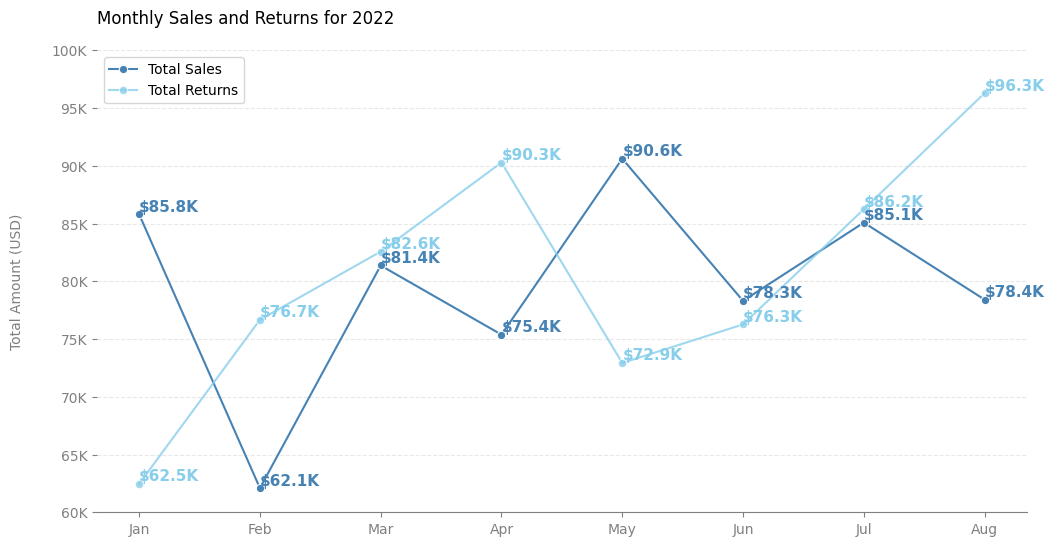

In [255]:

plt.figure(figsize=(12, 6))
g = sns.lineplot(x='Month', y='TotalAmount', data=month_sales, marker='o', label='Total Sales', color='steelblue')
sns.lineplot(x='Month', y='TotalAmount', data=returned_month_sales, marker='o', color='skyblue', alpha=0.8, label='Total Returns')
plt.title('Monthly Sales and Returns for 2022', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
ylabels = [f'{y:,.0f}K' for y in g.get_yticks() / 1000]
g.set_yticks(g.get_yticks())
g.set_yticklabels(ylabels)
plt.ylabel('Total Amount (USD)', color='grey', fontsize=10, labelpad=20)
plt.xlabel(None)

sns.despine()
plt.grid(axis='y', linestyle='--', color='lightgrey', alpha=0.5)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')

# Annotate sales and return amounts
for index, row in month_sales.iterrows():
    plt.text(row['Month'], row['TotalAmount'], format_currency(row['TotalAmount']),
             ha='left', va='bottom', color='steelblue', fontsize=11, fontweight='bold')

for index, row in returned_month_sales.iterrows():
    plt.text(row['Month'], row['TotalAmount'], format_currency(row['TotalAmount']),
             ha='left', va='bottom', color='skyblue', fontsize=11, fontweight='bold')

plt.legend()
plt.show()

**Observations and insights**

If the returns represent incomplete or cancelled purchases, it highlights a significant loss of revenue opportunities. 

In [11]:
potential_month_sales = df.groupby('Month', observed=False)['TotalAmount'].sum().reset_index()

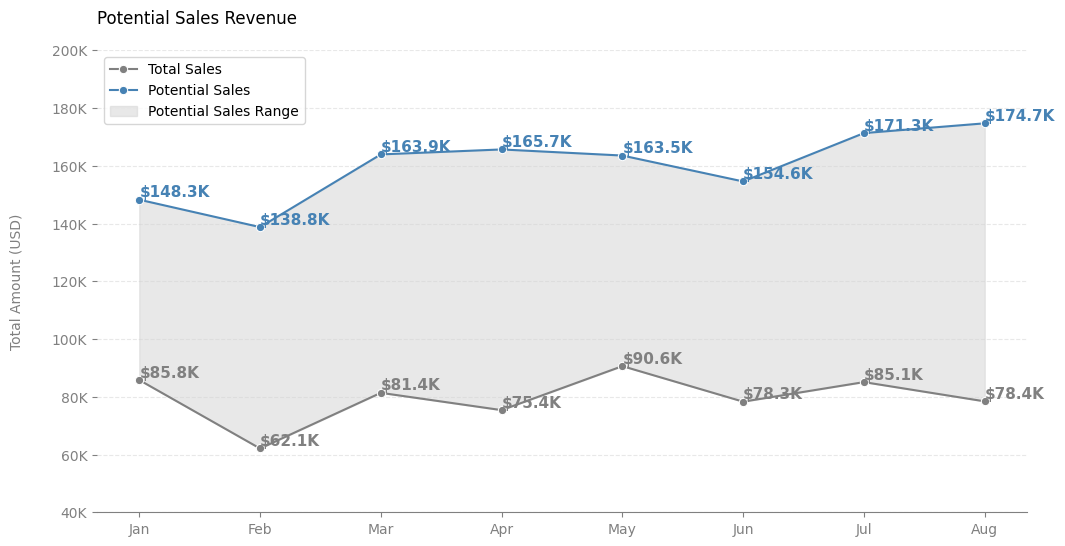

In [253]:
plt.figure(figsize=(12, 6))
g = sns.lineplot(x='Month', y='TotalAmount', data=month_sales, marker='o', color='grey', label='Total Sales')
sns.lineplot(x='Month', y='TotalAmount', data=potential_month_sales, marker='o', color='steelblue', label='Potential Sales')

# Fill the area between the two lines with grey
plt.fill_between(month_sales['Month'], month_sales['TotalAmount'], potential_month_sales['TotalAmount'], color='lightgrey', alpha=0.5, label='Potential Sales Range')

plt.title('Potential Sales Revenue', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
ylabels = [f'{y:,.0f}K' for y in g.get_yticks() / 1000]
g.set_yticks(g.get_yticks())
g.set_yticklabels(ylabels)
plt.ylabel('Total Amount (USD)', color='grey', fontsize=10, labelpad=20)
plt.xlabel(None)

sns.despine()
plt.grid(axis='y', linestyle='--', color='lightgrey', alpha=0.5)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')

# Annotate sales and return amounts
for index, row in month_sales.iterrows():
    plt.text(row['Month'], row['TotalAmount'], format_currency(row['TotalAmount']),
             ha='left', va='bottom', color='grey', fontsize=11, fontweight='bold')
    
for index, row in potential_month_sales.iterrows():
    plt.text(row['Month'], row['TotalAmount'], format_currency(row['TotalAmount']),
             ha='left', va='bottom', color='steelblue', fontsize=11, fontweight='bold')

plt.legend(loc='upper left')
plt.show()

In [13]:
# Fit linear regression models
reg_total_sales = LinearRegression().fit(month_sales.index.values.reshape(-1, 1), month_sales['TotalAmount'])
reg_potential_sales = LinearRegression().fit(potential_month_sales.index.values.reshape(-1, 1), potential_month_sales['TotalAmount'])

# Predictions
pred_total_sales = reg_total_sales.predict(month_sales.index.values.reshape(-1, 1))
pred_potential_sales = reg_potential_sales.predict(potential_month_sales.index.values.reshape(-1, 1))

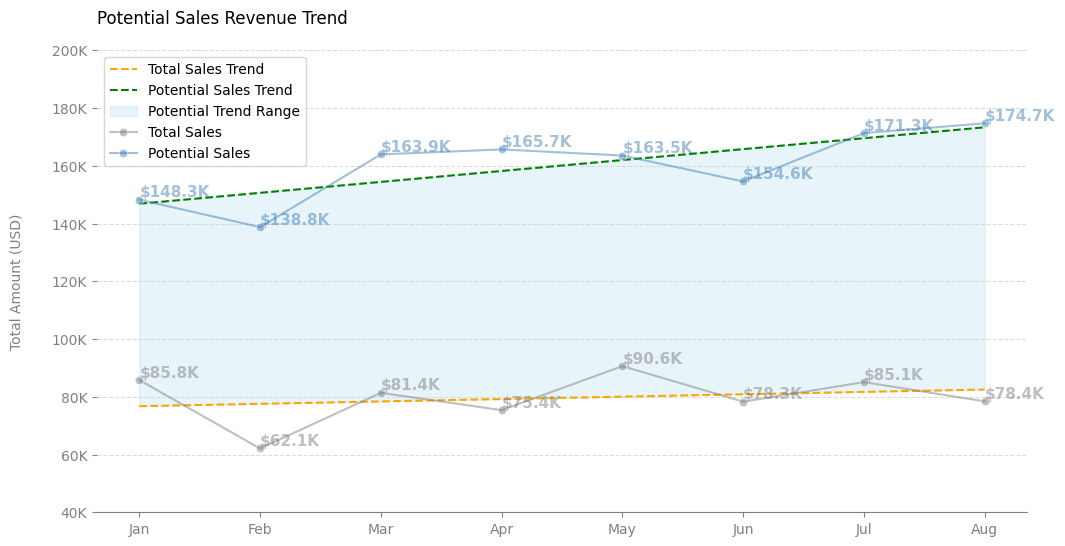

In [275]:
plt.figure(figsize=(12, 6))

# Trend lines
plt.plot(month_sales.index, pred_total_sales, color='orange', linestyle='--', label='Total Sales Trend')
plt.plot(potential_month_sales.index, pred_potential_sales, color='green', linestyle='--', label='Potential Sales Trend')
plt.fill_between(month_sales.index, pred_total_sales, pred_potential_sales, color='skyblue', alpha=0.2, label='Potential Trend Range')

g = sns.lineplot(x='Month', y='TotalAmount', data=month_sales, marker='o', color='grey', alpha=0.5, label='Total Sales')
sns.lineplot(x='Month', y='TotalAmount', data=potential_month_sales, marker='o', color='steelblue', alpha=0.5, label='Potential Sales')

plt.title('Potential Sales Revenue Trend', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
ylabels = [f'{y:,.0f}K' for y in g.get_yticks() / 1000]
g.set_yticks(g.get_yticks())
g.set_yticklabels(ylabels)
plt.ylabel('Total Amount (USD)', color='grey', fontsize=10, labelpad=20)
plt.xlabel(None)

sns.despine()
plt.grid(axis='y', linestyle='--', color='lightgrey', alpha=0.8)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')

# Annotate sales
for index, row in month_sales.iterrows():
    plt.text(row['Month'], row['TotalAmount'], format_currency(row['TotalAmount']),
             ha='left', va='bottom', color='grey', alpha=0.5, fontsize=11, fontweight='bold')
    
for index, row in potential_month_sales.iterrows():
    plt.text(row['Month'], row['TotalAmount'], format_currency(row['TotalAmount']),
             ha='left', va='bottom', color='steelblue', alpha=0.5, fontsize=11, fontweight='bold')

plt.legend(loc='upper left')
plt.show()

**Observations and insights**

While additional data would enhance the accuracy of trend analysis, the current data suggests that addressing those cancellations (identifying and addressing the root causes behind these returns) could help mitigate revenue loss and significantly improve overall business performance.

Potential issues affecting transaction completion, such as product quality and customer satisfaction, should be investigated.

In [15]:
month_sales['NetSales'] = month_sales['TotalAmount'] - returned_month_sales['TotalAmount']

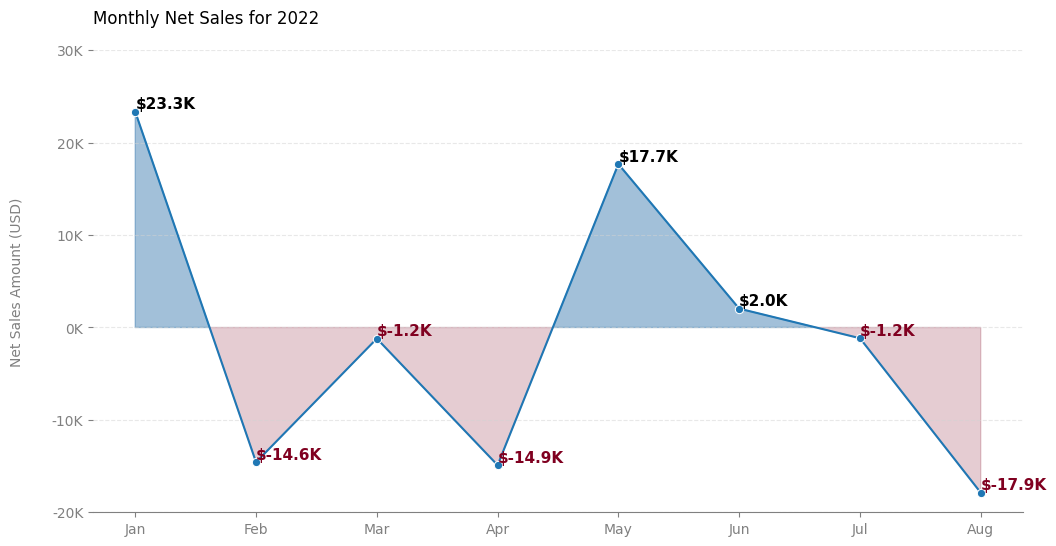

In [283]:
plt.figure(figsize=(12, 6))
g = sns.lineplot(x='Month', y='NetSales', data=month_sales, marker='o')

plt.fill_between(month_sales['Month'], month_sales['NetSales'], where=(month_sales['NetSales'] >= 0),
                 interpolate=True, color='steelblue', alpha=0.5)
plt.fill_between(month_sales['Month'], month_sales['NetSales'], where=(month_sales['NetSales'] < 0),
                 interpolate=True, color='#800020', alpha=0.2)

plt.title('Monthly Net Sales for 2022', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
ylabels = [f'{y:,.0f}K' for y in g.get_yticks() / 1000]
g.set_yticks(g.get_yticks())
g.set_yticklabels(ylabels)
plt.ylabel('Net Sales Amount (USD)', color='grey', fontsize=10, labelpad=20)
plt.xlabel(None)

sns.despine()
plt.grid(axis='y', linestyle='--', color='lightgrey', alpha=0.5)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')

for index, row in month_sales.iterrows():
    text_color = '#800020' if row['NetSales'] < 0 else 'black'
    plt.text(row['Month'], row['NetSales'], format_currency(row['NetSales']),
             ha='left', va='bottom', color=text_color, fontsize=11, fontweight='bold')

plt.show()

**Observations and insights**

If we assume that all those products marked in the IsReturned column were previously purchased but returned for a refund, the results are staggering. 

In both cases, further return analysis is necessary to gain a comprehensive understanding of customer behaviour and to create targeted strategies to address these challenges and optimise customer satisfaction and retention.


In [17]:
df['Weekday'] = df['OrderDate'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Weekday'] = pd.Categorical(df['Weekday'], categories=weekday_order, ordered=True)
weekday_sales = df[df['IsReturned'] != 1].groupby('Weekday', observed=False)['TotalAmount'].sum().reset_index()
weekday_sales_sorted = weekday_sales.sort_values(by='TotalAmount', ascending=False)

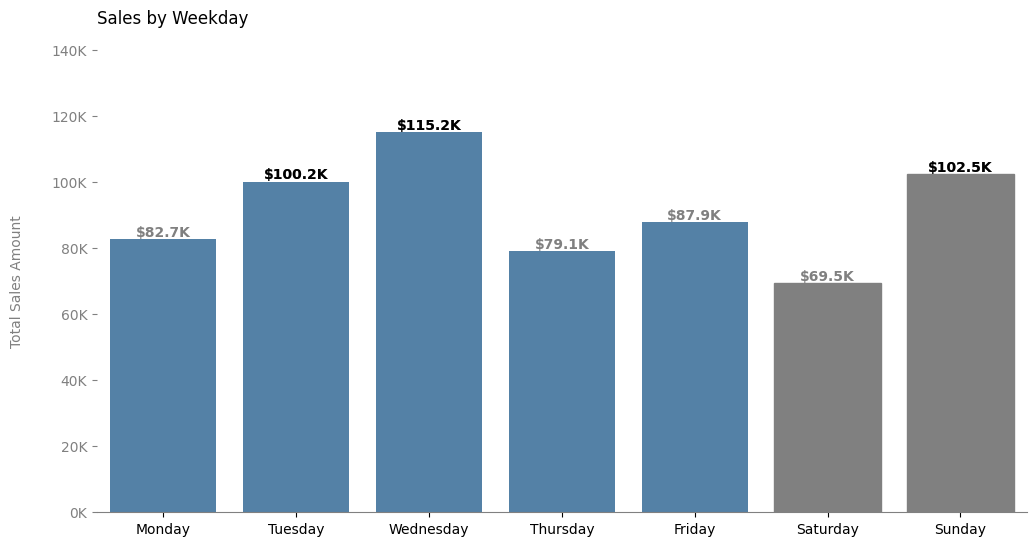

In [18]:
plt.figure(figsize=(12, 6))
g = sns.barplot(x='Weekday', y='TotalAmount', data=weekday_sales, color='steelblue')
# Set gray for weekends
for index, bar in enumerate(g.patches):
    if weekday_sales.loc[index, 'Weekday'] in ['Saturday', 'Sunday']:
        bar.set_color('grey')

plt.title('Sales by Weekday', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
ylabels = [f'{y:.0f}K' for y in g.get_yticks()/1000]
g.set_yticks(g.get_yticks())
g.set_yticklabels(ylabels)
plt.ylabel('Total Sales Amount', color='grey', fontsize=10, labelpad=20)
plt.xlabel(None)
for index, row in weekday_sales_sorted.iterrows():
    plt.text(index, row['TotalAmount'], f'${round(row["TotalAmount"] / 1000, 1)}K',
             ha='center', va='bottom', color='grey', fontweight='bold')
# Change text colour for top 3 weekdays
for index, row in weekday_sales_sorted.iloc[:3].iterrows():
    plt.text(index, row['TotalAmount'], f'${round(row["TotalAmount"] / 1000, 1)}K',
             ha='center', va='bottom', color='black', fontweight='bold')

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='grey')

plt.show()

**Observations and insights**

Based on sales data, sales are higher on Wednesdays, Tuesdays, and Sundays. This information should be taken into account when planning staffing and marketing strategies.

## 3. Customer Segmentation Analysis

In [19]:
corr = df.select_dtypes(include='number').corr()
corr.sort_values('TotalAmount', ascending = False)

,OrderID,ProductID,Quantity,Price,TotalAmount,CustomerID,IsReturned
TotalAmount,-0.000456,-0.003868,0.609311,0.727889,1.000000,-0.020609,-0.036446
Price,-0.010974,-0.006241,0.010006,1.000000,0.727889,-0.026160,-0.017664
Quantity,-0.008950,-0.016591,1.000000,0.010006,0.609311,-0.015927,-0.025447
OrderID,1.000000,0.000322,-0.008950,-0.010974,-0.000456,-0.001056,-0.019208
ProductID,0.000322,1.000000,-0.016591,-0.006241,-0.003868,-0.017102,0.028895
CustomerID,-0.001056,-0.017102,-0.015927,-0.026160,-0.020609,1.000000,0.008067
IsReturned,-0.019208,0.028895,-0.025447,-0.017664,-0.036446,0.008067,1.000000


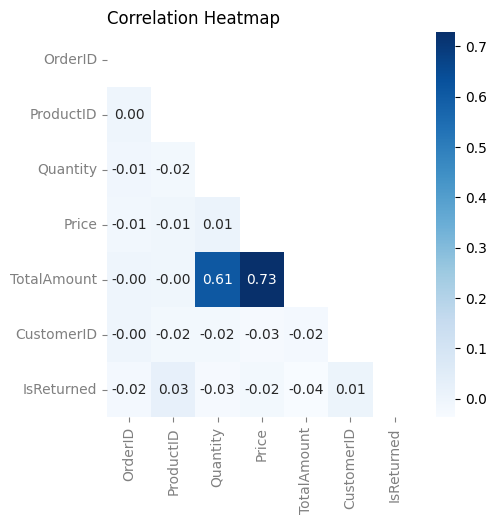

In [20]:
plt.figure(figsize=(5, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, mask=mask, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap', loc='left') # Remove. Add as subtitle to the presentation instead
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')
plt.show()

In [21]:
customer_sales = df[df['IsReturned'] != 1].groupby('CustomerID')['TotalAmount'].agg([('TotalAmount', 'sum'), ('UniqueOrders', 'count')])

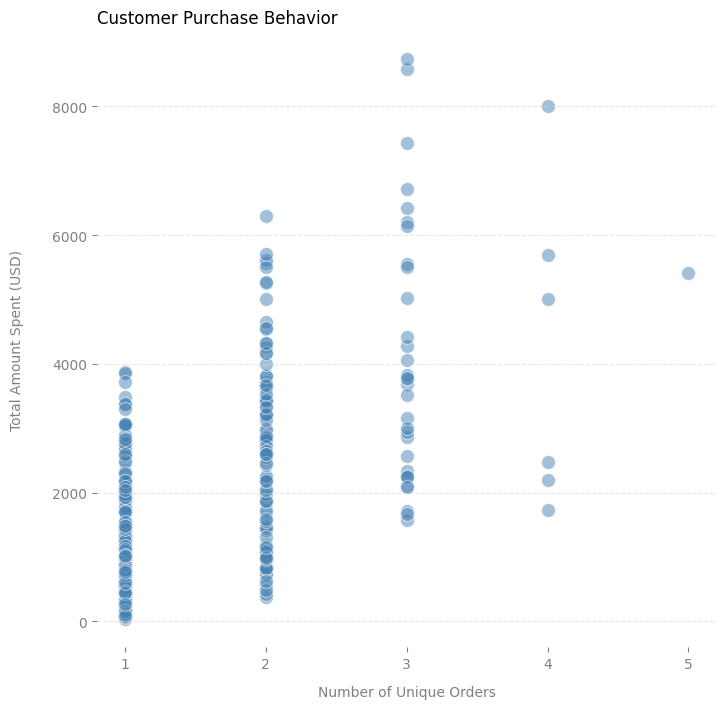

In [209]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='UniqueOrders', y='TotalAmount', data=customer_sales, color='steelblue', alpha=0.5, s=100)
plt.title('Customer Purchase Behavior', loc='left') # Remove. Add as subtitle to the presentation instead
plt.xlabel('Number of Unique Orders', color='grey', fontsize=10, labelpad=10)
plt.ylabel('Total Amount Spent (USD)', color='grey', fontsize=10, labelpad=20)

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis='y', linestyle='--', color='lightgrey', alpha=0.5)
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')
plt.xticks(range(1, max(customer_sales['UniqueOrders']) + 1))
plt.show()

In [23]:
customer_counts = customer_sales.groupby('UniqueOrders').size().reset_index(name='CustomerCount')
customer_counts_sorted = customer_counts.sort_values(by='UniqueOrders', ascending=True)

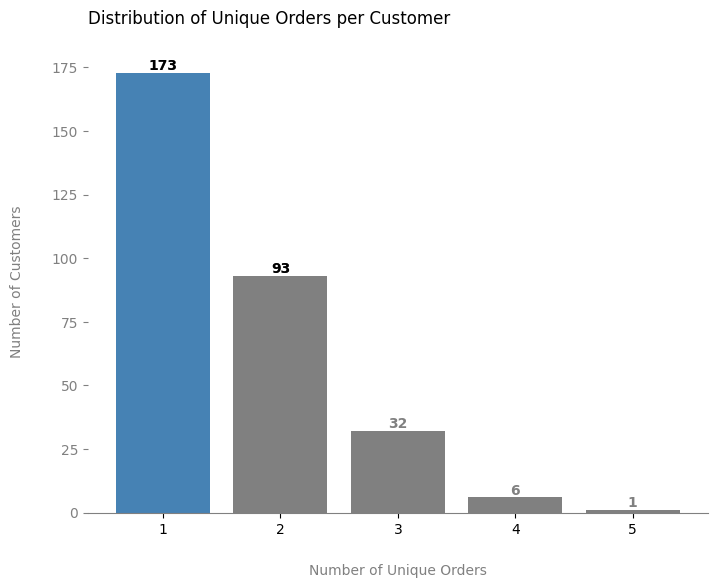

In [118]:

plt.figure(figsize=(8, 6))
sns.barplot(x='UniqueOrders', y='CustomerCount', data=customer_counts, color='grey')
plt.title('Distribution of Unique Orders per Customer', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
plt.xlabel('Number of Unique Orders', color='grey', fontsize=10, labelpad=20)
plt.ylabel('Number of Customers', color='grey', fontsize=10, labelpad=20)

for index, row in customer_counts.iterrows():
    plt.text(index, row['CustomerCount'], f'{row["CustomerCount"]}', 
             ha='center', va='bottom', color='grey', fontweight='bold')

for index, row in customer_counts_sorted[:2].iterrows():
    plt.text(index, row['CustomerCount'], f'{row["CustomerCount"]}', 
             ha='center', va='bottom', color='black', fontweight='bold')
    plt.bar(customer_counts_sorted.index[0], 
        customer_counts_sorted.iloc[0]['CustomerCount'], color='steelblue')

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='grey')
plt.show()

In [25]:
total_orders_amount = customer_sales.groupby('UniqueOrders').agg({'TotalAmount': ['count', 'sum']}).reset_index()
total_orders_amount.columns = ['UniqueOrders', 'CustomerCount', 'TotalAmount']
total_orders_amount_sorted = total_orders_amount.sort_values(by='TotalAmount', ascending=False)

In [196]:
total_orders_amount_sorted

,UniqueOrders,CustomerCount,TotalAmount
1,2,93,247257.14
0,1,173,228849.68
2,3,32,130422.93
3,4,6,25096.38
4,5,1,5416.40


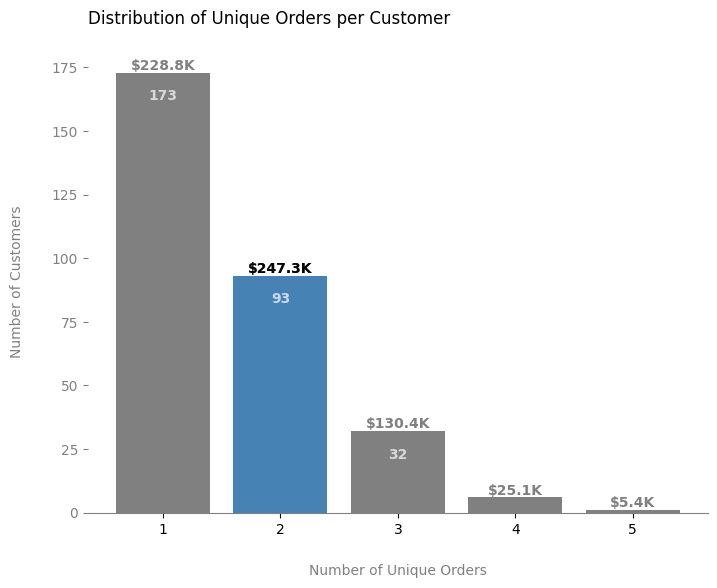

In [120]:
plt.figure(figsize=(8, 6))
sns.barplot(x='UniqueOrders', y='CustomerCount', data=total_orders_amount, color='grey')
plt.title('Distribution of Unique Orders per Customer', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
plt.xlabel('Number of Unique Orders', color='grey', fontsize=10, labelpad=20)
plt.ylabel('Number of Customers', color='grey', fontsize=10, labelpad=20)

for index, row in total_orders_amount.iterrows():
    plt.text(index, row['CustomerCount'], f'${round(row["TotalAmount"] / 1000, 1)}K', 
             ha='center', va='bottom', color='grey', fontweight='bold')

for index, row in total_orders_amount_sorted[:1].iterrows():
    plt.text(index, row['CustomerCount'], f'${round(row["TotalAmount"] / 1000, 1)}K', 
             ha='center', va='bottom', color='black', fontweight='bold')
    plt.bar(total_orders_amount_sorted.index[0], 
        total_orders_amount_sorted.iloc[0]['CustomerCount'], color='steelblue')

for index, row in customer_counts[:3].iterrows():
    plt.text(index, row['CustomerCount'], f'\n{row["CustomerCount"]}', 
             ha='center', va='top', color='white', fontweight='bold', alpha=0.7)

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='grey')
plt.show()

**Observations and insights**

The number of customers who placed only one unique order is higher (173 customers) compared to those who placed two unique orders (93 customers). However, the total amount generated by customers who placed two unique orders is greater (approximately 247.3k USD). 

This suggests that customers who made two unique orders tend to contribute more revenue individually, and may present greater potential for retention and future revenue generation as opposed to those with only one unique order. Their willingness to make multiple purchases indicates a higher level of trust and satisfaction, making them valuable targets for retention strategies and ongoing engagement efforts. Look into revenue expansion with this group through strategic marketing tactics.

Develop targeted engagement strategies for customers who placed only one unique order, aiming to encourage them to make repeat purchases. This could involve personalised recommendations, loyalty programs, or special promotions tailored to their preferences and purchasing behaviour. Collect feedback from this group of customers to understand their experience, preferences, and any potential obstacles to making additional purchases. Use this feedback to refine marketing strategies, improve product offerings, and optimize the overall customer journey.



In [27]:
customer_sales_sorted = customer_sales.sort_values(by='TotalAmount', ascending=False)

total_customers = len(customer_sales_sorted)
top_10_percent_threshold = int(total_customers * 0.1)
top_10_percent_customers = customer_sales_sorted.head(top_10_percent_threshold)
print(f'Recommendation: Consider a VIP program for those {len(top_10_percent_customers)} customers:\n')
print("Top 10% of Customers Based on Spending:")
top_10_percent_customers.style.background_gradient()


Recommendation: Consider a VIP program for those 30 customers:

Top 10% of Customers Based on Spending:


,TotalAmount,UniqueOrders
CustomerID,,
383,8728.860000,3
205,8579.150000,3
466,8008.910000,4
141,7429.050000,3
9,6722.230000,3
160,6425.240000,3
157,6304.270000,2
40,6204.820000,3
307,6136.780000,3


**Observations and insights**

It is interesting to explore this Top 10% category further. Also, we need to check if those customers are part of SalesEase's loyalty programs already and if those programs influence their spending.

In [28]:
top_customers_data = df[(df['IsReturned'] != 1) & (df['CustomerID'].isin(top_10_percent_customers.index))]
top_purchase_frequency = top_customers_data.groupby('CustomerID')['OrderDate'].count()
top_types_of_categories = top_customers_data.groupby('CustomerID')['Category'].nunique()
top_average_order_value = top_customers_data.groupby('CustomerID')['TotalAmount'].mean()
top_total_spent = top_customers_data.groupby('CustomerID')['TotalAmount'].sum()

top_purchase_behavior = pd.DataFrame({
    'PurchaseFrequency': top_purchase_frequency,
    'Categories': top_types_of_categories,
    'AverageOrder': top_average_order_value,
    'TotalSpent': top_total_spent
})
print('Purchase Behavior of Top 10% Customers:')
top_purchase_behavior.style.background_gradient()

Purchase Behavior of Top 10% Customers:


,PurchaseFrequency,Categories,AverageOrder,TotalSpent
CustomerID,,,,
2,2,2,2268.415000,4536.830000
9,3,2,2240.743333,6722.230000
40,3,2,2068.273333,6204.820000
76,2,2,2165.240000,4330.480000
88,2,2,2631.465000,5262.930000
97,3,2,1675.810000,5027.430000
110,3,2,1850.540000,5551.620000
127,2,1,2781.740000,5563.480000
141,3,3,2476.350000,7429.050000


**Observations and Insights**

The top 10% of customers (by spending) is an important group to the business's financial performance, as these high-spending individuals likely contribute a substantial portion of the company's total revenue. Implementing a VIP program for these top spenders has the potential to further cultivate customer loyalty and strengthen their relationship with the brand. Exclusive benefits, personalized offers, and enhanced customer experiences can incentivize VIP customers to increase their spending, refer others to the brand, and remain loyal over the long term.

Providing superior value and benefits to VIP customers can create a competitive advantage, driving customer satisfaction and retention while attracting new customers seeking similar privileges.

In [ ]:
df['OrderMonth'] = df['OrderDate'].dt.to_period('M')
customer_monthly_sales = df[df['IsReturned'] != 1].groupby(['CustomerID', 'OrderMonth']).agg(TotalAmount=('TotalAmount', 'sum'), UniqueOrders=('OrderID', 'nunique'))
customer_monthly_sales.reset_index(inplace=True)
customer_monthly_frequency = customer_monthly_sales.groupby('CustomerID')['OrderMonth'].nunique()

In [54]:
# Customer retention rate (CRR)
total_customers = len(customer_sales)
repeat_customers = len(customer_sales[customer_sales['UniqueOrders'] > 1])
retention_rate = (repeat_customers / total_customers) * 100

# Average order frequency (AOF)
average_order_frequency = customer_sales['UniqueOrders'].mean()
aof_month = customer_monthly_frequency.mean()

# Average Customer Lifetime Value (CLV)
average_clv = customer_sales['TotalAmount'].mean()


print(f'Customer Retention Rate: {retention_rate:.2f}%')
print(f'Average Order Frequency (AOF): {average_order_frequency:.2f}')
print(f'Monthly AOF: {aof_month:.2f}')
print(f'Average Customer Lifetime Value (CLV): {average_clv:.2f}')

Customer Retention Rate: 43.28%
Average Order Frequency (AOF): 1.59
Monthly AOF: 1.50
Average Customer Lifetime Value (CLV): 2088.66


In [191]:
customer_sales

,TotalAmount,UniqueOrders
CustomerID,,
1,3602.62,2
2,4536.83,2
3,648.45,1
7,1202.60,1
8,2339.92,1
...,...,...
496,2607.20,1
497,1489.44,1
498,1156.51,2


In [195]:
# Average Order Value (AOV)
total_revenue = customer_sales['TotalAmount'].sum()
total_orders = customer_sales['UniqueOrders'].sum()
aov = total_revenue / total_orders

print(f'Average Order Value (AOV): ${aov:.2f}')

Average Order Value (AOV): $1316.20


In [194]:
# Average Order Value (AOV) for top 10% of customers
total_revenue_top_10 = top_purchase_behavior['TotalSpent'].sum()
total_orders_top_10 = top_purchase_behavior['PurchaseFrequency'].sum()
aov_top_10 = total_revenue_top_10 / total_orders_top_10

# Average Customer Lifetime Value (CLV) for top 10% of customers
average_total_spent_top_10 = total_revenue_top_10 / len(top_purchase_behavior)

print(f'AOV for Top 10% of Customers: ${aov_top_10:.2f}')
print(f'Average CLV for Top 10% of Customers: ${average_total_spent_top_10:.2f}')

AOV for Top 10% of Customers: $2099.16
Average CLV for Top 10% of Customers: $5667.74


**Observations and insights**

Based on the size of the dataset provided the decision was made to calculate customer retention rate (CRR) based on the number of customers who have made more than one purchase. In the provided period only 43.28% of the customers continued to make purchases - a relatively low customer retention rate. *It may be more appropriate to **acquire more data** and calculate retention rate over a defined time frame, such as monthly or annually. This would provide more accurate insights into long-term retention trends, which can be used to develop targeted retention strategies.*

I would suggest tracking the monthly average order frequency (AOF) as it can provide a more detailed understanding of customer purchasing behaviour over time and can help in adjusting marketing strategies and promotions to better align with customer preferences.

The calculated average CLV is 2088.66 USD, indicating the expected total revenue contribution from each customer over their lifetime. Increasing the average customer lifetime value is essential for long-term business success. Strategies such as improving customer satisfaction, offering premium products or services, and providing exceptional customer experiences can help maximize CLV and drive sustainable revenue growth. Investing in VIP customers identified above directly focuses on maximising customer lifetime value (CLV), and aligns with the company's long-term growth strategy.


## 4. Product Analysis

In [31]:
top_5_products_by_category = df[df['IsReturned'] != 1].groupby(['Category', 'ProductName']).agg({'Quantity': 'sum', 'TotalAmount': 'sum'}).reset_index()
top_5_products_by_category = top_5_products_by_category.sort_values(['Category', 'Quantity'], ascending=[True, False])
top_5_products_by_category = top_5_products_by_category.groupby('Category').head(5).reset_index(drop=True)
top_5_products_by_category.style.background_gradient()

,Category,ProductName,Quantity,TotalAmount
0,Electronics,Product_295,15,4704.570000
1,Electronics,Product_444,13,5980.080000
2,Electronics,Product_374,10,2330.950000
3,Electronics,Product_477,10,2020.090000
4,Electronics,Product_143,9,1056.260000
5,Fashion,Product_174,11,4734.510000
6,Fashion,Product_228,11,5494.550000
7,Fashion,Product_409,10,2566.100000
8,Fashion,Product_220,9,4212.010000
9,Fashion,Product_328,9,5073.870000


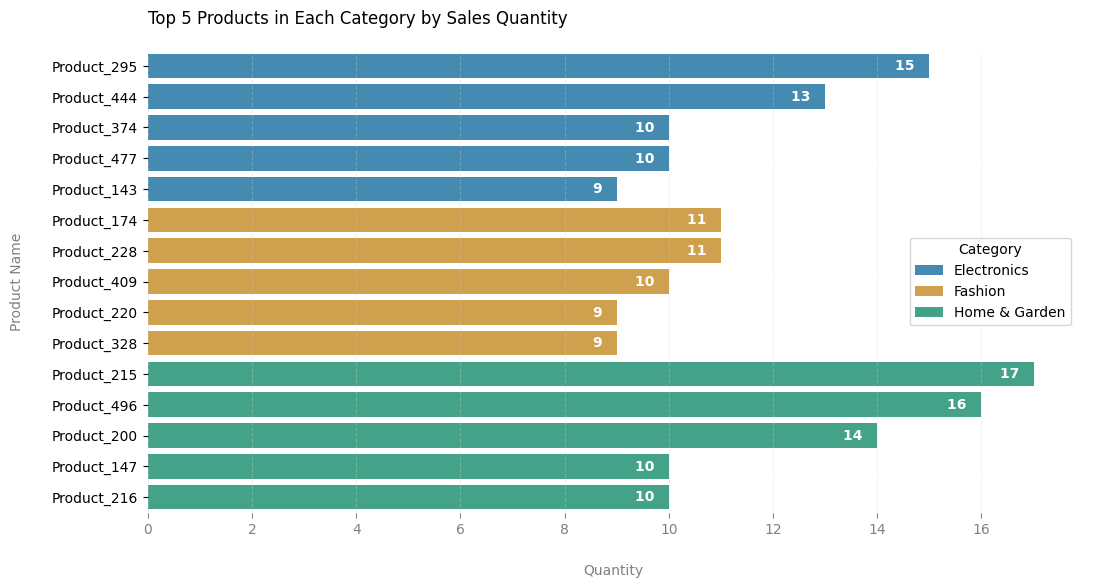

In [130]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='ProductName', hue='Category', data=top_5_products_by_category, palette='colorblind', alpha=0.8)
plt.title('Top 5 Products in Each Category by Sales Quantity', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
plt.xlabel('Quantity', color='grey', fontsize=10, labelpad=20)
plt.ylabel('Product Name', color='grey', fontsize=10, labelpad=20)

for index, row in top_5_products_by_category.iterrows():
    plt.text(row['Quantity'], index, f'{row["Quantity"]}   ', 
            ha='right', va='center', color='white', fontweight='bold')
    plt.text(row['Quantity'], index, f' ${round(row["TotalAmount"] / 1000, 1)}K', 
            ha='left', va='center', color='grey', alpha=0, fontweight='bold')

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis='x', linestyle='--', color='lightgrey', alpha=0.3)
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='black')
plt.legend(title='Category', loc='center right')
plt.show()

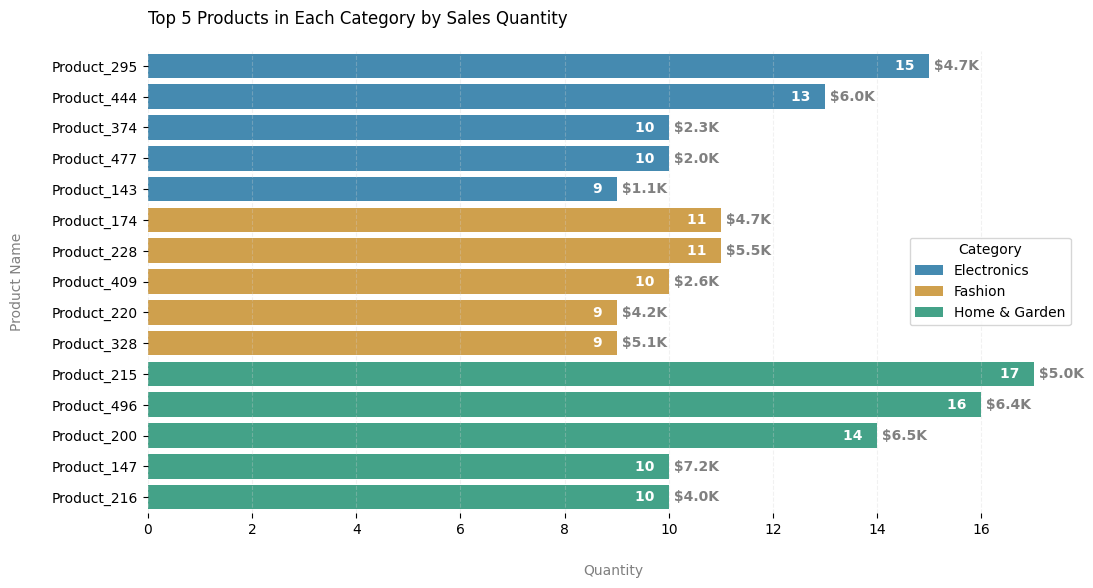

In [127]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='ProductName', hue='Category', data=top_5_products_by_category, palette='colorblind', alpha=0.8)
plt.title('Top 5 Products in Each Category by Sales Quantity', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
plt.xlabel('Quantity', color='grey', fontsize=10, labelpad=20)
plt.ylabel('Product Name', color='grey', fontsize=10, labelpad=20)

for index, row in top_5_products_by_category.iterrows():
    plt.text(row['Quantity'], index, f' ${round(row["TotalAmount"] / 1000, 1)}K', 
            ha='left', va='center', color='grey', fontweight='bold')
    plt.text(row['Quantity'], index, f'{row["Quantity"]}   ', 
            ha='right', va='center', color='white', fontweight='bold')

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis='x', linestyle='--', color='lightgrey', alpha=0.3)
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.legend(title='Category', loc='center right')
plt.show()

In [34]:
top_in_category = top_5_products_by_category.sort_values(['Category', 'TotalAmount'], ascending=[True, False])
top_in_category = top_in_category.groupby('Category').head(1).reset_index(drop=True)

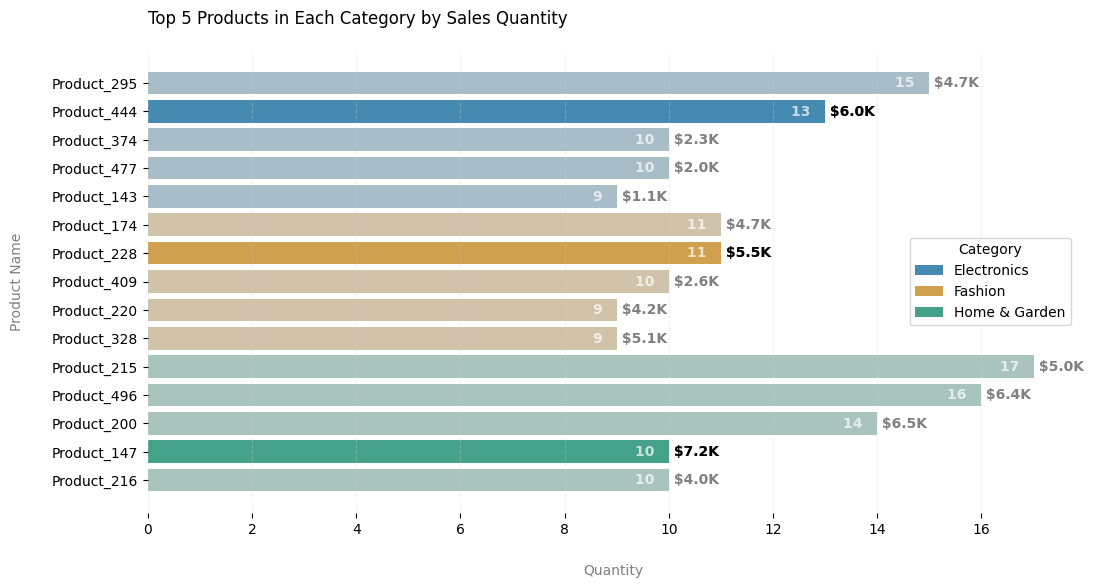

In [135]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='ProductName', hue='Category', data=top_5_products_by_category, palette='colorblind', alpha=0.8)
plt.title('Top 5 Products in Each Category by Sales Quantity', loc='left', y=1.04) # Remove. Add as subtitle to the presentation instead
plt.xlabel('Quantity', color='grey', fontsize=10, labelpad=20)
plt.ylabel('Product Name', color='grey', fontsize=10, labelpad=20)

for index, row in top_5_products_by_category.iterrows():
    plt.text(row['Quantity'], index, f' ${round(row["TotalAmount"] / 1000, 1)}K', 
            ha='left', va='center', color='grey', fontweight='bold')
    plt.text(row['Quantity'], index, f'{row["Quantity"]}   ', 
            ha='right', va='center', color='white', fontweight='bold', alpha=0.7)
    if row['ProductName'] in top_in_category['ProductName'].values:
        plt.text(row['Quantity'], index, f' ${round(row["TotalAmount"] / 1000, 1)}K', 
            ha='left', va='center', color='black', fontweight='bold')
    else:
        plt.barh(index, row['Quantity'], color='lightgrey', alpha=0.7)

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis='x', linestyle='--', color='lightgrey', alpha=0.3)
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.legend(title='Category', loc='center right')
plt.show()

In [36]:
top_products_am_category = df[df['IsReturned'] != 1].groupby(['Category', 'ProductName']).agg({'Quantity': 'sum', 'TotalAmount': 'sum'}).reset_index()
top_products_am_category = top_products_am_category.sort_values(['Category', 'TotalAmount'], ascending=[True, False])
top_5_products_am_category = top_products_am_category.groupby('Category').head(5).reset_index(drop=True)
top_5_products_am_category.style.background_gradient()

,Category,ProductName,Quantity,TotalAmount
0,Electronics,Product_444,13,5980.080000
1,Electronics,Product_247,8,4930.720000
2,Electronics,Product_470,8,4721.760000
3,Electronics,Product_295,15,4704.570000
4,Electronics,Product_333,8,4591.480000
5,Fashion,Product_387,9,6080.210000
6,Fashion,Product_228,11,5494.550000
7,Fashion,Product_328,9,5073.870000
8,Fashion,Product_174,11,4734.510000
9,Fashion,Product_220,9,4212.010000


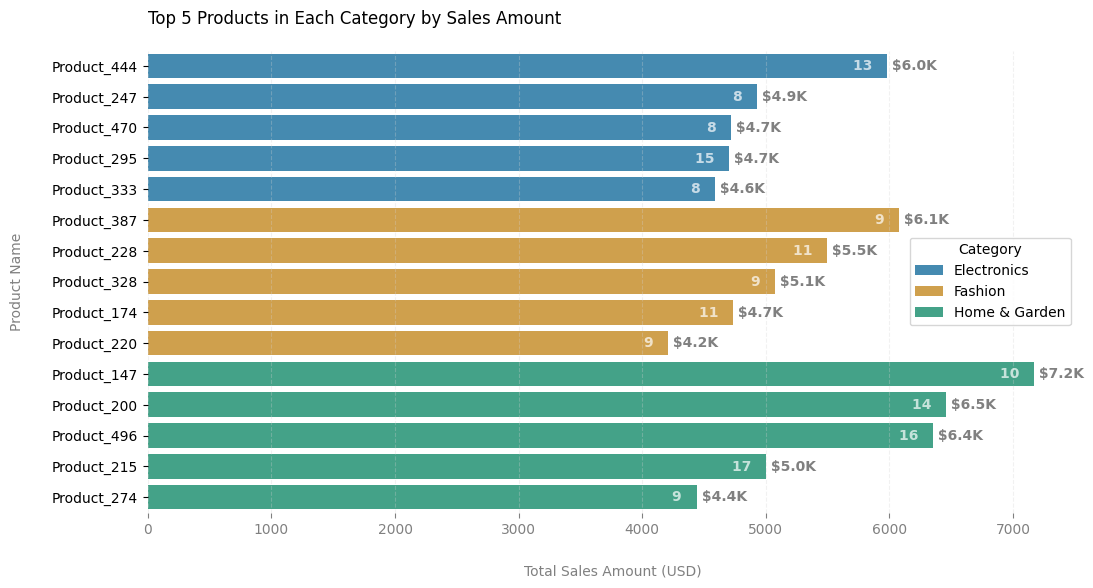

In [215]:
plt.figure(figsize=(12, 6))
sns.barplot(x='TotalAmount', y='ProductName', hue='Category', data=top_5_products_am_category, palette='colorblind', alpha=0.8)
plt.title('Top 5 Products in Each Category by Sales Amount', loc='left', y=1.04) 
plt.xlabel('Total Sales Amount (USD)', color='grey', fontsize=10, labelpad=20)
plt.ylabel('Product Name', color='grey', fontsize=10, labelpad=20)

for index, row in top_5_products_am_category.iterrows():
    plt.text(row['TotalAmount'], index, f' ${round(row["TotalAmount"] / 1000, 1)}K', 
            ha='left', va='center', color='grey', fontweight='bold')
    plt.text(row['TotalAmount'], index, f'{row["Quantity"]}   ', 
            ha='right', va='center', color='white', fontweight='bold', alpha=0.7)

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis='x', linestyle='--', color='lightgrey', alpha=0.3)
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='black')
plt.legend(title='Category', loc='center right')
plt.show()

In [38]:
common_products = set(top_5_products_by_category['ProductName']).intersection(set(top_5_products_am_category['ProductName']))
common_top_5_products_am_category = top_5_products_am_category[top_5_products_am_category['ProductName'].isin(common_products)]

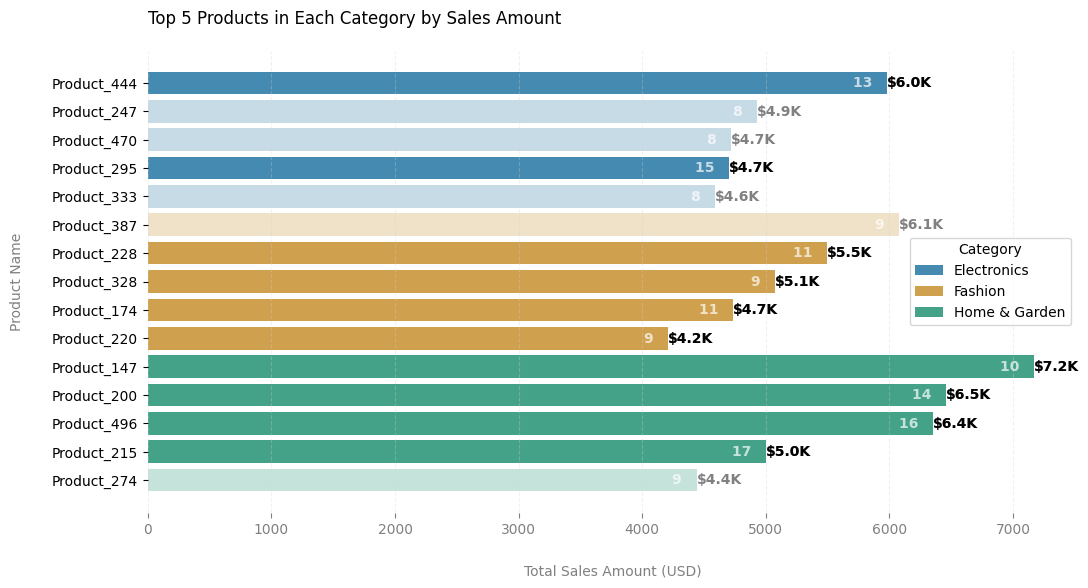

In [213]:
plt.figure(figsize=(12, 6))
sns.barplot(x='TotalAmount', y='ProductName', hue='Category', data=top_5_products_am_category, palette='colorblind', alpha=0.8)
plt.title('Top 5 Products in Each Category by Sales Amount', loc='left', y=1.04) 
plt.xlabel('Total Sales Amount (USD)', color='grey', fontsize=10, labelpad=20)
plt.ylabel('Product Name', color='grey', fontsize=10, labelpad=20)

for index, row in top_5_products_am_category.iterrows():
    plt.text(row['TotalAmount'], index, f'${round(row["TotalAmount"] / 1000, 1)}K', 
            ha='left', va='center', color='grey', fontweight='bold')
    plt.text(row['TotalAmount'], index, f'{row["Quantity"]}   ', 
            ha='right', va='center', color='white', fontweight='bold', alpha=0.7)

for index, row in common_top_5_products_am_category.iterrows():
    plt.text(row['TotalAmount'], index, f'${round(row["TotalAmount"] / 1000, 1)}K', 
            ha='left', va='center', color='black', fontweight='bold')

for index, row in top_5_products_am_category.iterrows():
    if row['ProductName'] not in common_products:
        plt.barh(index, row['TotalAmount'], color='white', alpha=0.7)

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis='x', linestyle='--', color='lightgrey', alpha=0.3)
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='black')
plt.legend(title='Category', loc='center right')
plt.show()

**Observations and insights**

Across all categories, there is a variation between the top-selling products by quantity and those by total sales amount, indicating that higher quantities don't always translate to higher revenue.

Further analysis is needed to identify the factors contributing to the success of top-performing products, such as customer preferences, marketing strategies, or product features to adapt product offerings.

## 5. Payment and Returns Analysis

In [40]:
returned_orders = df[df['IsReturned'] == 1]
# Calculate the return rate for each category
total_orders_by_category = df.groupby('Category')['OrderID'].count().reset_index()
returned_orders_by_category = returned_orders.groupby('Category')['OrderID'].count().reset_index()
return_rate_by_category = pd.merge(total_orders_by_category, returned_orders_by_category, on='Category', how='left')
return_rate_by_category.columns = ['Category', 'TotalOrders', 'ReturnedOrders']
return_rate_by_category['ReturnRate'] = (return_rate_by_category['ReturnedOrders'] / return_rate_by_category['TotalOrders']) * 100

# Calculate the return rate for each payment method
total_orders_by_payment = df.groupby('PaymentMethod')['OrderID'].count().reset_index()
returned_orders_by_payment = returned_orders.groupby('PaymentMethod')['OrderID'].count().reset_index()
return_rate_by_payment = pd.merge(total_orders_by_payment, returned_orders_by_payment, on='PaymentMethod', how='left')
return_rate_by_payment.columns = ['PaymentMethod', 'TotalOrders', 'ReturnedOrders']
return_rate_by_payment['ReturnRate'] = (return_rate_by_payment['ReturnedOrders'] / return_rate_by_payment['TotalOrders']) * 100

# Display the return rates by category and payment method
print(return_rate_by_category)
print()
print(return_rate_by_payment)

        Category  TotalOrders  ReturnedOrders  ReturnRate
0    Electronics          336             172   51.190476
1        Fashion          343             179   52.186589
2  Home & Garden          321             165   51.401869

  PaymentMethod  TotalOrders  ReturnedOrders  ReturnRate
0          Cash          311             176   56.591640
1   Credit Card          343             170   49.562682
2        PayPal          346             170   49.132948


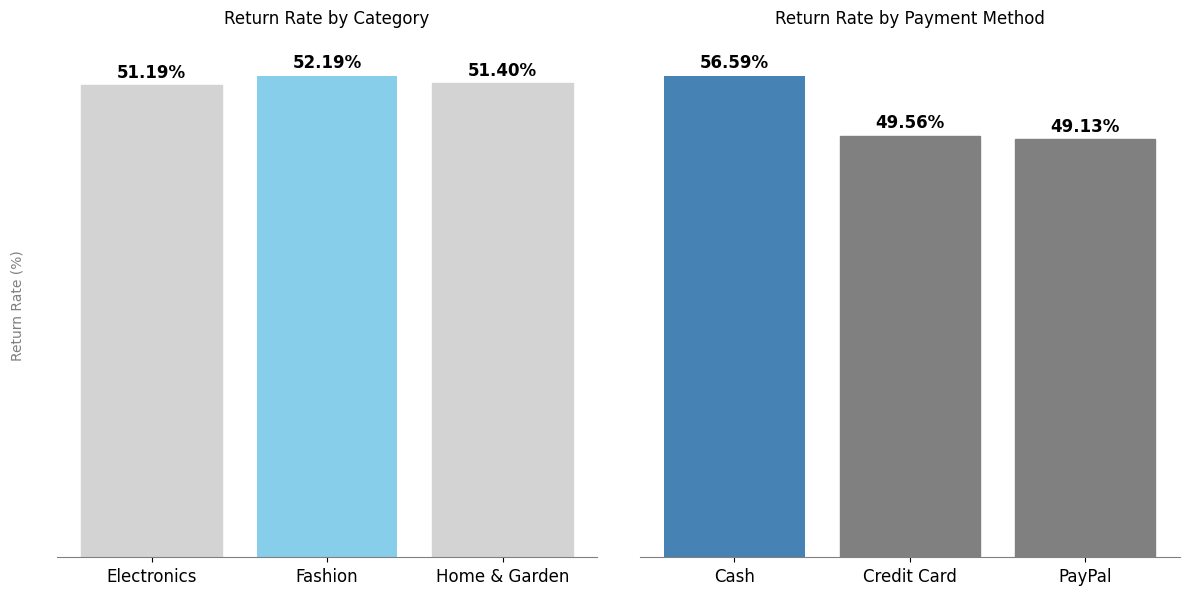

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Rates by category
bars1 = axes[0].bar(return_rate_by_category['Category'], return_rate_by_category['ReturnRate'], color='skyblue')
axes[0].set_title('Return Rate by Category', y=1.04) # Remove. Add as subtitle to the presentation instead
axes[0].set_xlabel(None)
axes[0].set_ylabel('Return Rate (%)', color='grey', fontsize=10)
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{height:.2f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize = 12 ,fontweight='bold')
for i, bar in enumerate(bars1):
    if i == np.argmax(return_rate_by_category['ReturnRate']):
        continue
    bar.set_color('lightgrey')

# Rates by payment method
bars2 = axes[1].bar(return_rate_by_payment['PaymentMethod'], return_rate_by_payment['ReturnRate'], color='steelblue')
axes[1].set_title('Return Rate by Payment Method', y=1.04) # Remove. Add as subtitle to the presentation instead
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
for bar in bars2:
    height = bar.get_height()
    axes[1].annotate(f'{height:.2f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize = 12 ,fontweight='bold')
for i, bar in enumerate(bars2):
    if i == np.argmax(return_rate_by_payment['ReturnRate']):
        continue
    bar.set_color('grey')

plt.tight_layout()
sns.despine()
for ax in axes:
    # ax.yaxis.set_visible(False)
    ax.tick_params(axis='y', colors='white')
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('grey')
    ax.tick_params(axis='x', colors='black', labelsize=12)
plt.show()

In [76]:
returned_products_count = returned_orders.groupby('ProductName')['IsReturned'].count().reset_index()
most_returned_products = returned_products_count.sort_values('IsReturned', ascending=False).head(10)
most_returned_products

,ProductName,IsReturned
279,Product_489,6
142,Product_297,6
57,Product_183,5
208,Product_392,5
206,Product_390,5
109,Product_248,5
204,Product_388,4
64,Product_193,4
73,Product_205,4
163,Product_326,4


In [180]:
returned_count_frequency = returned_products_count['IsReturned'].value_counts().reset_index()
returned_count_frequency.columns = ['Return Count', 'Frequency']
returned_count_frequency = returned_count_frequency.sort_values('Return Count', ascending=False)

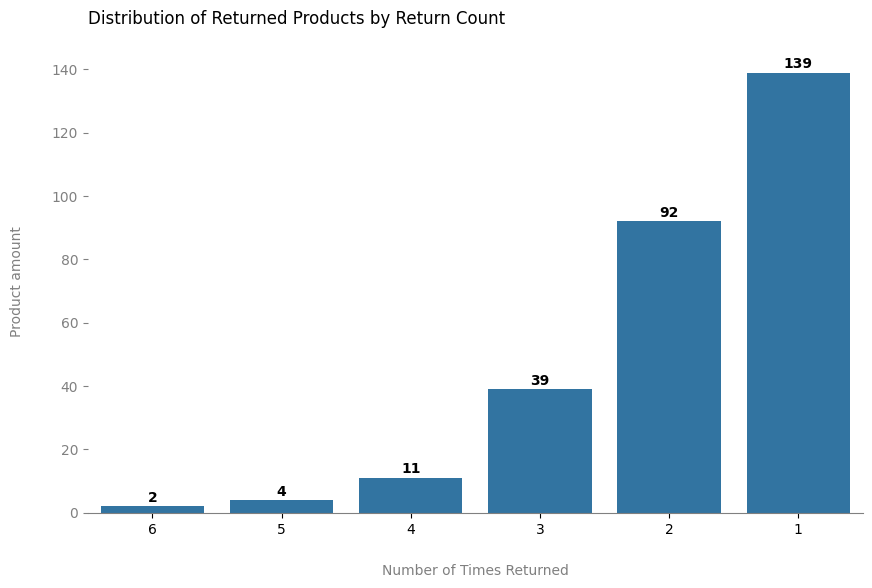

In [210]:
categories = returned_count_frequency['Return Count'].tolist()
if not returned_count_frequency.sort_values('Return Count', ascending=False).equals(returned_count_frequency):
    categories.reverse()

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Return Count', y='Frequency', data=returned_count_frequency, order=categories)
plt.title('Distribution of Returned Products by Return Count', loc='left', y=1.04) 
plt.xlabel('Number of Times Returned', color='grey', fontsize=10, labelpad=20)
plt.ylabel('Product amount', color='grey', fontsize=10, labelpad=20)

for i, bar in enumerate(bars.patches):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, int(bar.get_height()), 
             ha='center', va='bottom' ,fontweight='bold')

sns.despine()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='grey')
plt.show()

**Observations and insights**

The insights above highlight the need to investigate the reasons behind the higher return rates for certain products and devise strategies to mitigate returns, potentially by improving product quality, addressing customer concerns, or providing better product descriptions. I would suggest starting with Product_489 and Product_297 which were returned six times, continuing with 4 products that were returned five times, and so on.

In [43]:
count_by_category = returned_orders.groupby(['ProductID', 'Category'])['IsReturned'].count().reset_index()
most_returned_products = count_by_category.sort_values('IsReturned', ascending=False).head(10)
most_returned_products

,ProductID,Category,IsReturned
406,489,Electronics,4
205,297,Electronics,4
231,326,Electronics,3
359,445,Home & Garden,3
112,205,Electronics,3
383,468,Electronics,3
295,392,Fashion,3
148,235,Fashion,3
36,138,Home & Garden,3
290,390,Fashion,3


In [44]:
product_489 = df[df['ProductID'] == 489]
product_489

,OrderID,ProductID,Category,ProductName,Quantity,Price,TotalAmount,OrderDate,CustomerID,PaymentMethod,SalesChannel,IsReturned,Month,Weekday
58,59,489,Fashion,Product_489,1,742.49,742.49,2022-07-05 13:16:29,186,Cash,In-Store,0,Jul,Tuesday
677,678,489,Home & Garden,Product_489,5,526.27,2631.35,2022-04-01 19:59:00,111,Cash,Mobile App,1,Apr,Friday
830,831,489,Electronics,Product_489,5,179.80,899.00,2022-02-24 07:25:36,426,Cash,Mobile App,1,Feb,Thursday
850,851,489,Electronics,Product_489,1,205.61,205.61,2022-06-30 09:25:42,188,Cash,In-Store,1,Jun,Thursday
876,877,489,Electronics,Product_489,3,412.88,1238.64,2022-07-29 21:59:19,217,Cash,Website,1,Jul,Friday
892,893,489,Home & Garden,Product_489,4,627.30,2509.20,2022-06-12 06:37:24,70,Credit Card,Mobile App,1,Jun,Sunday
971,972,489,Electronics,Product_489,4,175.97,703.88,2022-04-21 18:17:45,6,PayPal,Website,1,Apr,Thursday


In [45]:
product_297 = df[df['ProductID'] == 297]
product_297

,OrderID,ProductID,Category,ProductName,Quantity,Price,TotalAmount,OrderDate,CustomerID,PaymentMethod,SalesChannel,IsReturned,Month,Weekday
31,32,297,Home & Garden,Product_297,1,440.84,440.84,2022-04-05 17:59:01,412,PayPal,In-Store,0,Apr,Tuesday
107,108,297,Electronics,Product_297,5,220.44,1102.20,2022-05-07 15:54:37,435,Cash,Website,1,May,Saturday
234,235,297,Fashion,Product_297,5,673.82,3369.10,2022-04-08 12:55:47,126,PayPal,Mobile App,0,Apr,Friday
284,285,297,Electronics,Product_297,4,406.08,1624.32,2022-06-24 14:28:56,103,Cash,Website,1,Jun,Friday
515,516,297,Fashion,Product_297,5,733.23,3666.15,2022-02-06 14:48:59,21,PayPal,Website,1,Feb,Sunday
634,635,297,Home & Garden,Product_297,2,180.97,361.94,2022-06-12 04:58:37,132,Credit Card,Website,0,Jun,Sunday
655,656,297,Electronics,Product_297,2,285.38,570.76,2022-08-12 23:18:15,197,Credit Card,In-Store,1,Aug,Friday
699,700,297,Fashion,Product_297,1,252.12,252.12,2022-04-01 10:44:26,302,PayPal,Mobile App,1,Apr,Friday
703,704,297,Electronics,Product_297,2,275.38,550.76,2022-08-02 14:39:34,318,PayPal,Mobile App,1,Aug,Tuesday
965,966,297,Electronics,Product_297,5,318.63,1593.15,2022-06-29 01:31:57,482,Credit Card,Website,0,Jun,Wednesday


**Observations and insights**

Analysing top returned products it has become clear that the same product is listed and purchased across different categories, including Home & Garden, Electronics, and Fashion. Also, for the ProductID 297 price ranges from 180.97USD to 733.23USD per unit within just eight months. Also, there are no sales observed within 28 and even 90 days before the return. That all **can indicate errors in data collection.**



## 6. Summary: Key Insights and Impact

- The analysis revealed fluctuations in sales throughout the year, with peaks in January, May, and July, potentially attributed to seasonal promotions and events. Further data collection, including historical data, is recommended to provide a comprehensive understanding of long-term sales trends and facilitate more accurate forecasting. Understanding these trends can inform strategic planning and resource allocation.

- **High return rates** were observed, indicating **lost revenue opportunities**. Addressing the root causes behind returns, such as product quality or customer satisfaction issues, could mitigate revenue loss and enhance overall business performance. Additional data collection and analysis are necessary to gain deeper insights into return patterns and devise effective strategies for reducing them.

- Customer segmentation highlighted the significance of repeat purchasers, suggesting **targeted strategies to encourage repeat purchases** and cultivate customer loyalty. Also, implementing a **VIP program for high-spending customers** has the potential to drive revenue growth and strengthen customer relationships.

- Further analysis is required to **identify factors contributing to the success of top-selling products**, such as customer preferences, marketing strategies, or product features to optimise product offerings and drive revenue growth.